# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from model.sim_components import Simulator

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [2]:
# Common settings of the simulation
sim_time = 20
time_delta = 0.01

# Settings dict
settings = {}
settings['demand_rate'] = 1
settings['repair_rate'] = 2
settings['Q_service'] = 2
settings['Q_repair'] = 4
settings['S_depot'] = 2
settings['S_warehouse'] = 1

demand_rates = [1]
repair_rates = [2]
s_services = [2]


# Initialise empty dataframe
sim_dfs = pd.DataFrame()

# Create and run simulator for all settings
for demand_rate in demand_rates:
    for repair_rate in repair_rates:
        for s_service in s_services:
            # Set parameters
            settings['demand_rate'] = demand_rate
            settings['repair_rate'] = repair_rate
            settings['S_depot'] = s_service
            
            # Run simulation
            simulator = Simulator(time_delta, sim_time, settings)
            simulator.run()
            
            # Save output to master data frame
            sim_data = simulator.create_output_df()
            for setting, value in settings.items():
                sim_data[setting] = value
                
            sim_dfs = sim_dfs.append(sim_data)
            
# Change time column
sim_dfs.time = sim_dfs.time * time_delta

100%|██████████| 2000/2000 [00:04<00:00, 473.90it/s]


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [3]:
# Get a feeling for the data
sim_dfs.head()

,service_stock_depot,service_orders,service_back_orders,service_stock_position,repair_stock_depot,time,service_stock_warehouse,repair_stock_warehouse,repair_shipment,service_order,...,hold_cost_serviceables,back_cost_serviceables,hold_cost_repairables,costs,demand_rate,repair_rate,Q_service,Q_repair,S_depot,S_warehouse
0,1.99,2.0,0.0,3.99,0.01,0.00,1,0,0,0,...,0.0598,0.0,0.0299,2.0897,1,2,2,4,2,1
1,1.98,2.0,0.0,3.98,0.02,0.01,1,0,0,0,...,0.0596,0.0,0.0298,2.0894,1,2,2,4,2,1
2,1.97,2.0,0.0,3.97,0.03,0.02,1,0,0,0,...,0.0594,0.0,0.0297,2.0891,1,2,2,4,2,1
3,1.96,2.0,0.0,3.96,0.04,0.03,1,0,0,0,...,0.0592,0.0,0.0296,2.0888,1,2,2,4,2,1
4,1.95,2.0,0.0,3.95,0.05,0.04,1,0,0,0,...,0.059,0.0,0.0295,2.0885,1,2,2,4,2,1


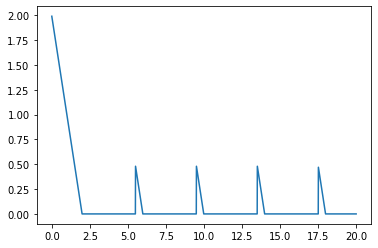

In [4]:
plt.plot(sim_dfs['time'], sim_dfs['service_stock_depot'])

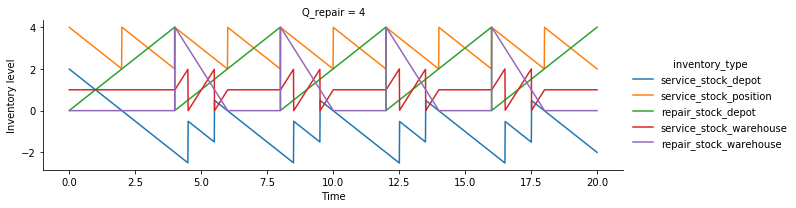

In [5]:
# Get all relevant inventory level variables
# Create long format
inventory_data = sim_dfs.melt(value_vars=['service_stock_depot', 'service_stock_position', 'service_back_orders', 
                                          'repair_stock_depot', 'service_stock_warehouse', 'repair_stock_warehouse'], 
                              id_vars=['time'] + list(settings.keys()),
                              value_name='inventory_level', var_name='inventory_type'
                              )

# Plot lines over time 
g = sns.FacetGrid(inventory_data[inventory_data.time >= 0], col='Q_repair', col_wrap=1, hue='inventory_type', aspect=3, sharey=False)

# Plot lines
g.map(plt.plot, 'time', 'inventory_level').add_legend().set_axis_labels('Time', 'Inventory level')

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the warehouse to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the warehouse costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [16]:
# Transform data types to float
sim_dfs.costs = sim_dfs.costs.astype(float)

# Total avg cost of simulation
sim_dfs.groupby(list(settings.keys())).agg({'costs':'mean'})

,,,,,,costs
demand_rate,repair_rate,Q_service,Q_repair,S_depot,S_warehouse,
1,2,2,4,2,1,0.407067


### Average inventory levels per cycle

In [15]:
sim_dfs.dtypes

service_stock_depot        float64
service_stock_position     float64
repair_stock_depot         float64
time                       float64
service_stock_warehouse     object
repair_stock_warehouse      object
repair_shipment              int64
service_order                int64
order_cost_service           int64
order_cost_repair            int64
hold_cost_serviceables      object
back_cost_serviceables     float64
hold_cost_repairables       object
costs                       object
demand_rate                  int64
repair_rate                  int64
Q_service                    int64
Q_repair                     int64
S_depot                      int64
S_warehouse                  int64
dtype: object